# CNN with/without augmentation

In this notebook, we will use simple CNN neural network, and compare result between with/without using image preprocessing

*data augmentation*  means randomly shifting/ rotating/ flipping/ lighting your images. It reduces overfitting, and helps to get better results. 





# Load data

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

test = pd.read_csv('../input/digit-recognizer/test.csv')
train = pd.read_csv('../input/digit-recognizer/train.csv')

# check how labels are distributed

In [ ]:

num_classes = 10
x_train = train.drop('label', axis = 1)
y_train = train['label']

# visualization of label count
g = sns.countplot(y_train)
y_train.value_counts()


# checking whether there is NanValue in label counts

In [ ]:
y_train.isnull().sum()

# change data type, normalizing

In [ ]:
x_test = test

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()



y_train = keras.utils.to_categorical(y_train, num_classes)
x_test = x_test.to_numpy()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:

x_train_normal = x_train/ 255.0
x_test_normal = x_test / 255.0



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
batch_size = 64
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)



# Data augmentation visualization

In [ ]:
# datagen will randomly generate rotated, zoomed, shifted image
datagen = ImageDataGenerator(
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)  

### we did not flip images because it can make confusions between numbers like 6 and 9

In [ ]:
X_train3 = x_train_normal[9,].reshape((1,28,28,1))
Y_train3 = y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = x_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = x_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Preparing and training model!

In [ ]:
# model1 and model 2 have same structure, but model1 will be trained with image augmentation, and model2 will be trained
# without image augmentation
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=[28, 28, 1]))
model1.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model1.add(MaxPool2D((2, 2)))
model1.add(Dropout(0.20))
model1.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model1.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])


model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=[28, 28, 1]))
model2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.20))
model2.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model2.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)


In [ ]:
from sklearn.model_selection import train_test_split
x_train_normal_split, x_valid_normal, y_train_split, y_valid = train_test_split(x_train_normal, y_train, test_size = 0.2, random_state=42)

In [ ]:
datagen.fit(x_train_normal_split)
# fitting model with image augmentation
h1 = model1.fit(datagen.flow(x_train_normal_split,y_train_split, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_valid_normal,y_valid),
                              verbose = 1, steps_per_epoch=x_train_normal_split.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],) 


# fitting model without image augmentation
h2 = model2.fit(x_train_normal_split,y_train_split, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_valid_normal,y_valid),
                              verbose = 1, steps_per_epoch=x_train_normal_split.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],) #without augmentation


# Making CSV file

In [ ]:
result_with_augmentation = model1.predict(x_test_normal)
result_without_augmentation = model2.predict(x_test_normal)

In [ ]:
result_with_augmentation_int = np.argmax(result_with_augmentation, axis = 1)
result_without_augmentation_int = np.argmax(result_without_augmentation, axis = 1)
print(result_with_augmentation_int)

In [ ]:
submission_with_augmentation = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
submission_without_augmentation = pd.read_csv('../input/digit-recognizer/sample_submission.csv')


In [ ]:
submission_with_augmentation['Label'] = result_with_augmentation_int
submission_without_augmentation['Label'] = result_without_augmentation_int

In [ ]:
submission_with_augmentation.to_csv("/kaggle/working/with_augmentation.csv", index=False)
submission_without_augmentation.to_csv("/kaggle/working/without_augmentation.csv", index=False)
print("making csv complete")

# Comparing results with/without augmentation

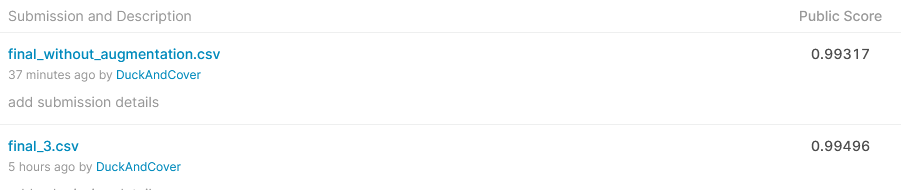


# Thank you for reading this notebook!